In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

import warnings

import scipy
from scipy import stats
from scipy.stats import randint as randint

In [24]:
warnings.filterwarnings('ignore')  # Чтобы избавиться от предупреждений при построении графиков

Данное исследование берет в свою основу общественный консенсус среди фанатов футбола о том, что российские футболисты получают несправедливо высокие зарплаты, которые не соответствуют их навыкам игры. Ниже мы изучим, насколько это соответствует правде, при помощи обучения моделей на основе показателей навыков и зарплат игроков по всему миру и сравнения с отечественными коллегами

База данных взята из Kaggle и представляет собой характеристики футболистов по всему миру, включенных в копмьютерную игру FIFA 22. Компания EA, которая занимается разработкой проекта, составляется профессиональными тренерами и наблюдателями на основе обзора и оценок игроков в матчах. Ссылка на источник базы данных: https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset

Откроем базу данных и изучим, с чем предстоит работать:

In [25]:
df = pd.read_csv('players_22.csv')

In [26]:
pd.options.display.max_columns = None

In [27]:
df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [28]:
df.shape

(19239, 110)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(16), int64(44), object(50)
memory usage: 16.1+ MB


В переменной player_positions указаны несколько позиций, на которых умеет играть футболист (через запятую). Отберем только первую позицию, потому что она наиболее предпочтительна для самого игрока. Т.к. позиции указаны подробно (вингер, фуллбек и т.д.), упростим нашу переменную позиций, сведя ее к четырем основным категориям амплуа на поле: нападающий, полузащитник, защитник, вратарь.

Помимо этого, модель не понимает категориальные значения, так что создадим фиктивные переменные для наших четырех категорий:

In [30]:
def pos_maker(player):
    try:
        return player.split(',')[0]
    except:
        return player

In [31]:
df['position'] = df['player_positions'].apply(lambda x: pos_maker(x))

df.replace(['RW', 'ST', 'LW', 'CF'], 'Attacker', inplace=True)
df.replace(['CM', 'CDM', 'LM', 'CAM', 'RM'], 'Midfielder', inplace=True)
df.replace(['CB', 'LB', 'RB', 'LWB', 'RWB'], 'Defender', inplace=True)
df.replace(['GK'], 'Goalkeeper', inplace=True)

In [32]:
df['position'].unique()  # Убеждаемся, что всё прошло верно

array(['Attacker', 'Midfielder', 'Goalkeeper', 'Defender'], dtype=object)

In [33]:
df = pd.get_dummies(df, prefix='position', prefix_sep='=', columns=['position'])

df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,position=Attacker,position=Defender,position=Goalkeeper,position=Midfielder
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,Attacker,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,Attacker,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,1,0,0,0
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,Attacker,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,Attacker,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,1,0,0,0
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,Attacker,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,Attacker,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams

Т.к. переменная weak_foot показывает нам навык игры слабой ногой (для правши слабая - это левая, и наоборот) от 1 до 5, установим минимальный порог в оценку 4 для игроков-амбидекстров (способных играть обеими ногами). Сохраним ее в новую переменную и дропнем старую.

In [34]:
df = df.assign(ambidextrous = df.weak_foot)

df.loc[df.ambidextrous < 4, 'ambidextrous'] = 0
df.loc[df.ambidextrous > 3, 'ambidextrous'] = 1
df.drop(['weak_foot'], axis=1, inplace=True)

Переменная real_face показывает наличие реального лица игрока в его модельке в игре. Переименуем ее в celebrity как демонстрацию медийности и известности игрока: если у него есть лицо в игре, значит он очень популярен в реальном мире, и наоборот

In [35]:
df.rename(columns = {'real_face':'celebrity'}, inplace = True)

df.loc[df.celebrity == 'Yes', 'celebrity'] = 1
df.loc[df.celebrity == 'No', 'celebrity'] = 0

In [36]:
Построим тепловую карту и посмотрим, коррелируют ли какие-либо переменные

SyntaxError: invalid syntax (Temp/ipykernel_4824/3066620563.py, line 1)

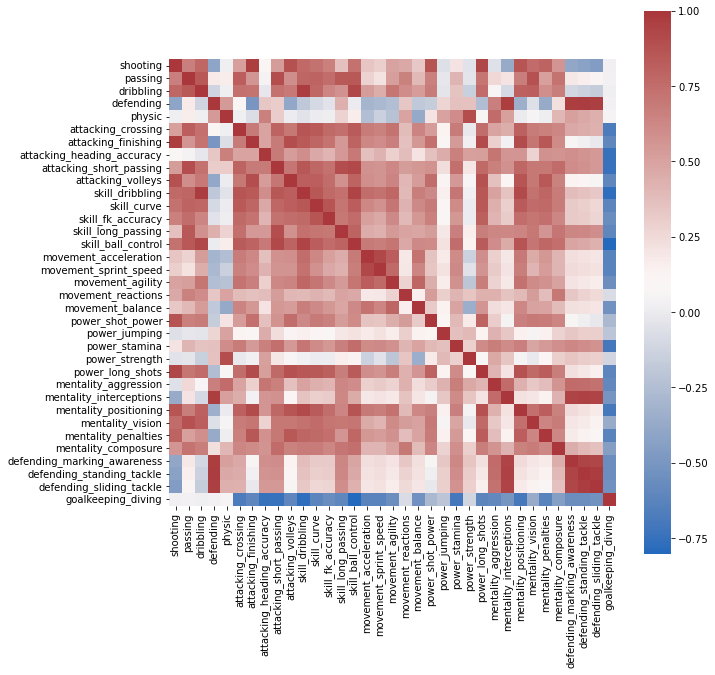

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

df_matrix = df.iloc[: , 37:72].copy()
corrMatrix = df_matrix.corr()
sns.heatmap(corrMatrix, xticklabels=True, yticklabels=True, cmap='vlag', square=True)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.show()

Shooting сильно пересекается с attacking_finishing, power_long_shots, power_shot_power - так как по сути эти переменные и формируют общий показатель shooting. 

С остальными четырьмя общими показателями (особенно - defending) наблюдаем то же самое - они формируются другими, более подробными характеристиками игрока. Чтобы корреляции не нарушали поведение модели, эти общие показатели можно опустить без потери в наполненности данных - а подробные остаются для дальнейшей работы.

Также избавимся от несодержательных или просто лишних переменных (от переменных pace, shooting, passing, dribbling, defending и physic избавились из-за сильных корреляций с другими переменными в датафрейме.

In [38]:
df.shape

(19239, 114)

In [39]:
df = df.drop(['sofifa_id', 'player_url', 'short_name', 'dob', 'club_team_id', 'player_positions', 'club_jersey_number', 'club_loaned_from', 'club_joined', 'club_contract_valid_until', 
               'nationality_id', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'preferred_foot', 'work_rate', 'body_type', 'release_clause_eur', 'player_tags', 'player_traits', 
                'club_position', 'goalkeeping_speed', 'club_name', 'league_level', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur'], axis=1)

In [40]:
df = df.drop(df.loc[:, 'ls':'nation_flag_url'].columns, axis = 1)

In [41]:
df.head()

,long_name,overall,potential,wage_eur,age,height_cm,weight_kg,league_name,nationality_name,skill_moves,international_reputation,celebrity,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position=Attacker,position=Defender,position=Goalkeeper,position=Midfielder,ambidextrous
0,Lionel Andrés Messi Cuccittini,93,93,320000.0,34,170,72,French Ligue 1,Argentina,4,5,1,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,1,0,0,0,1
1,Robert Lewandowski,92,92,270000.0,32,185,81,German 1. Bundesliga,Poland,4,5,1,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,1,0,0,0,1
2,Cristiano Ronaldo dos Santos Aveiro,91,91,270000.0,36,187,83,English Premier League,Portugal,5,5,1,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,1,0,0,0,1
3,Neymar da Silva Santos Júnior,91,91,270000.0,29,175,68,French Ligue 1,Brazil,5,5,1,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,1,0,0,0,1
4,Kevin De Bruyne,91,91,350000.0,30,181,70,English Premier League,Belgium,4,4,1,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,0,0,0,1,1


In [42]:
df.shape

(19239, 51)

Влияние возраста на зарплаты всегда нелинейно, так что добавим квадратичный признак 

<AxesSubplot:>

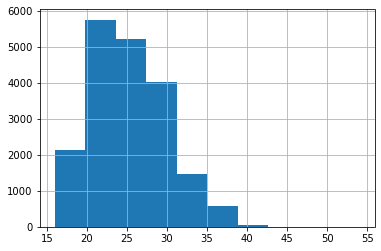

In [43]:
df['age'].hist()

In [44]:
df['age_sq'] = df['age'].pow(2)
df.head()

,long_name,overall,potential,wage_eur,age,height_cm,weight_kg,league_name,nationality_name,skill_moves,international_reputation,celebrity,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position=Attacker,position=Defender,position=Goalkeeper,position=Midfielder,ambidextrous,age_sq
0,Lionel Andrés Messi Cuccittini,93,93,320000.0,34,170,72,French Ligue 1,Argentina,4,5,1,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,1,0,0,0,1,1156
1,Robert Lewandowski,92,92,270000.0,32,185,81,German 1. Bundesliga,Poland,4,5,1,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,1,0,0,0,1,1024
2,Cristiano Ronaldo dos Santos Aveiro,91,91,270000.0,36,187,83,English Premier League,Portugal,5,5,1,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,1,0,0,0,1,1296
3,Neymar da Silva Santos Júnior,91,91,270000.0,29,175,68,French Ligue 1,Brazil,5,5,1,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,1,0,0,0,1,841
4,Kevin De Bruyne,91,91,350000.0,30,181,70,English Premier League,Belgium,4,4,1,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,0,0,0,1,1,900


В основе исследования - модели, обученные на топ-5 лигах Европы, поскольку они считаются эталонными в вопросах менеджмента и управления финансами. Выбор в топ-5 был сделан на основе рейтинга UEFA: https://ru.uefa.com/nationalassociations/uefarankings/

In [45]:
# Переменные, которые будут использоваться в модели
# Не берем position=Midfielder, чтобы исключить проблему мультиколлинеарности в 4ке бинарных признаков из переменной position

feature_names = ['overall', 'potential','skill_moves','international_reputation', 'attacking_crossing','attacking_finishing','attacking_heading_accuracy',
                 'attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy',
                 'skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility',
                 'movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina',
                 'power_strength','power_long_shots','mentality_aggression','mentality_interceptions',
                 'mentality_positioning','mentality_vision','mentality_penalties','mentality_composure',
                 'defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle',
                 'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning',
                 'goalkeeping_reflexes','ambidextrous','position=Attacker','position=Defender',
                 'position=Goalkeeper', 'age', 'age_sq']

In [46]:
topfive = df.loc[df['league_name'].isin(['French Ligue 1', 'German 1. Bundesliga', 'English Premier League', 'Spain Primera Division', 'Italian Serie A'])]
topfive_cols = list(topfive.columns)

topfive.shape

(2976, 52)

Мы не станем избавляться от выбросов в данных, поскольку у нас они являются информативными для модели: например, если Месси имеет рейтинг 92, и он лежит за пределом порогов выбросов, то при обработке выбросов он превращается в игрока, который при среднем рейтинге получает огромную зарплату. В случае, если мы избавляемся от выбросов еще и в целевой переменной, то мы лишаем модель возможности обучиться на данных игроков, у которых и высокий рейтинг, и высокая зарплата

Теперь разобьем наш датасет на тренировочную и валидационную выборки. Тестовая выборка будет выделяться отдельно, но валидационная также необходима, чтобы оценить качество модели

In [47]:
target_name = 'wage_eur'

X = topfive[feature_names]
y = topfive[target_name]

Стандартизуем данные при помощи StandardScaler. Создадим модель - Адабустинг с линейной регрессией в качестве базового эстиматора, подберем гиперпараметры при помощи RandomizedSearchCV. Увидим, что на тренировочной выборке R^2 и MAE модели составляют 0.66 и примерно ~14700. В целом цифры неплохие, особенно с учетом того, что на тестововой выборке ничего почти не портится - значит, модель не страдает от существенного переобучения

In [48]:
scale= StandardScaler()
scaled = scale.fit_transform(topfive[feature_names])

In [49]:
scaled.shape

(2976, 44)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.3, shuffle=True, random_state=123)

In [51]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (2083, 44)
y_train Shape: (2083,)
X_test Shape: (893, 44)
y_test Shape: (893,)


In [52]:
modelReg = AdaBoostRegressor(base_estimator=LinearRegression(fit_intercept=True, n_jobs=-1), learning_rate=2, n_estimators=148, loss='linear', random_state=123)

In [55]:
# Данный процесс требует некоторого ожидания, на системе с i3-12100F потребовалось больше минуты

param_grid = {
   'learning_rate': randint(0.5, 3.1),
   'n_estimators': randint(50, 501),
   'loss': ['linear', 'square', 'exponential']}


cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

random_search = RandomizedSearchCV(modelReg, param_distributions=param_grid, n_iter=100, n_jobs=-1,
                                   cv=cv, scoring='neg_mean_absolute_error', random_state=123, verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=AdaBoostRegressor(base_estimator=LinearRegression(n_jobs=-1),
                                               learning_rate=2,
                                               n_estimators=148,
                                               random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023FEDFC86A0>,
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023FEDFD6D60>},
                   random_state=123, scoring='neg_mean_absolute_error',
                   verbose=10)

In [56]:
print(random_search.best_score_)
print(random_search.best_params_)

-14926.975605530159
{'learning_rate': 2, 'loss': 'linear', 'n_estimators': 148}


In [57]:
def evaluate_preds(true_values, pred_values):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mean_absolute_error(true_values, pred_values), 3)))
    
    plt.figure(figsize=(8, 8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 400000], [0, 400000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

    plt.show()

R2:	0.66
MAE:	14741.125


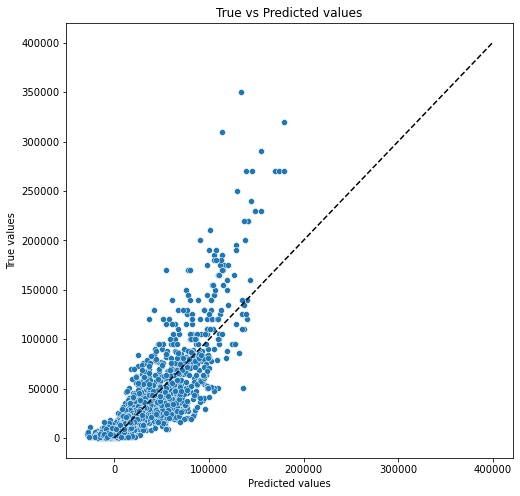

In [58]:
modelReg.fit(X_train, y_train)
y_train_preds = modelReg.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.627
MAE:	15413.55


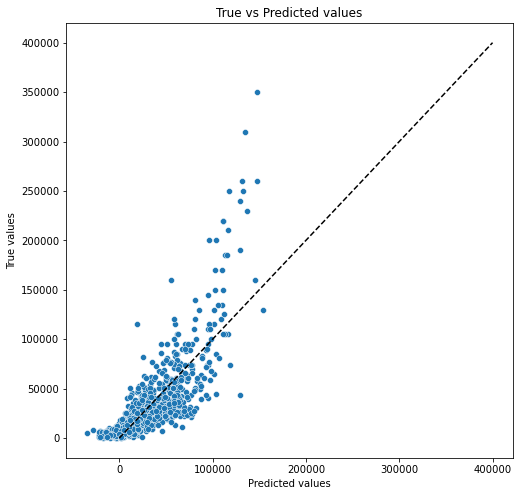

In [59]:
y_test_preds = modelReg.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [60]:
coefs = []
for clf,w in zip(modelReg.estimators_, modelReg.estimator_weights_):
    coefs.append(clf.coef_*w)
coefs = np.array(coefs).mean(axis=0)

<AxesSubplot:xlabel='Названия признаков'>

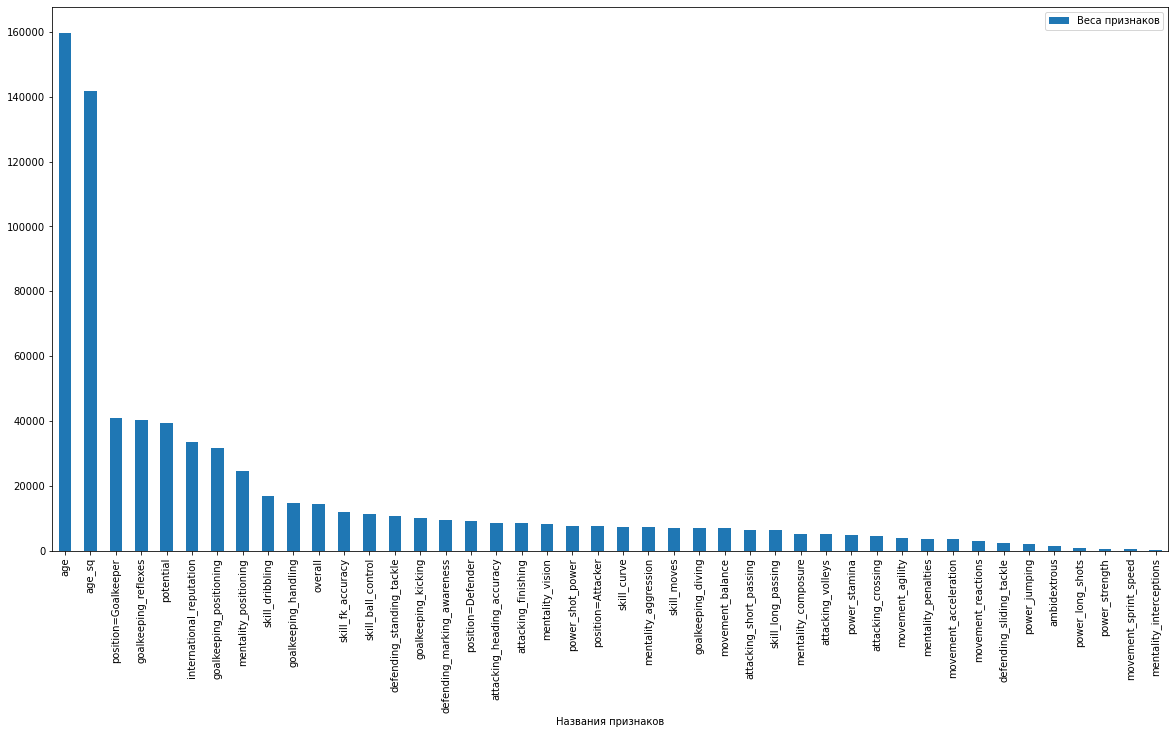

In [61]:
a1 = np.array(feature_names)
a2 = np.array(abs(coefs))
for_bar = pd.DataFrame({'Названия признаков':a1, 'Веса признаков':a2})
for_bar.sort_values(by='Веса признаков', ascending=False, inplace=True)
plt.rcParams["figure.figsize"] = (20, 10)
for_bar.plot('Названия признаков', 'Веса признаков', kind='bar')

Теперь поработаем над тестовой выборкой - футболисты из лиги "Russian Premier League'

In [62]:
rpl = df.loc[df['league_name']=='Russian Premier League']
rpl.head(5)

,long_name,overall,potential,wage_eur,age,height_cm,weight_kg,league_name,nationality_name,skill_moves,international_reputation,celebrity,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position=Attacker,position=Defender,position=Goalkeeper,position=Midfielder,ambidextrous,age_sq
220,Mário Figueira Fernandes,82,82,57000.0,30,187,80,Russian Premier League,Russia,3,2,0,75,56,72,82,58,80,66,39,71,79,79,84,79,80,61,71,84,87,75,60,77,76,76,73,53,76,79,81,83,12,13,14,13,12,0,1,0,0,0,900
390,Igor Akinfeev,80,80,26000.0,35,186,78,Russian Premier League,Russia,1,3,1,19,13,18,23,10,15,19,13,22,22,51,50,53,71,45,59,62,35,72,13,24,17,11,59,10,67,18,13,13,77,72,78,82,84,0,0,1,0,0,1225
444,Quincy Anton Promes,80,80,68000.0,29,174,72,Russian Premier League,Netherlands,4,3,1,78,79,66,79,69,81,75,76,73,80,87,88,85,82,78,81,79,81,64,76,65,38,81,81,74,79,46,48,40,10,13,6,7,13,0,0,0,1,1,841
673,Victor Moses,78,78,56000.0,30,177,79,Russian Premier League,Nigeria,4,2,1,76,67,69,76,64,82,75,61,70,81,77,76,75,74,79,74,66,78,68,69,66,71,73,72,75,75,70,71,70,9,7,8,16,16,0,0,0,1,1,900
758,Roman Zobnin,78,80,51000.0,27,182,78,Russian Premier League,Russia,4,1,0,73,62,70,78,55,77,65,66,76,81,74,78,70,77,65,68,63,90,66,63,69,73,68,72,67,73,79,76,75,10,8,13,15,9,0,0,0,1,0,729


In [63]:
rpl.shape

(82, 52)

In [64]:
scaled_rpl = scale.fit_transform(rpl[feature_names])

In [65]:
X_rpl = scaled_rpl
y_rpl = rpl[target_name]

R2:	-0.749
MAE:	14891.019


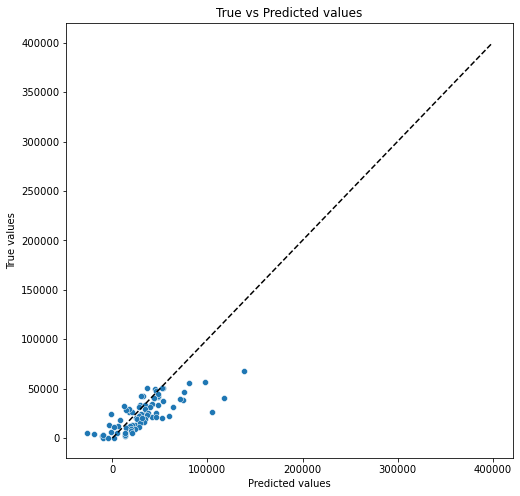

In [66]:
y_rpl_preds = modelReg.predict(X_rpl)
evaluate_preds(y_rpl, y_rpl_preds)

In [67]:
a = {'Реальная зарплата':y_rpl,'Предсказанная зарплата':y_rpl_preds}
b = pd.DataFrame(a)
b['Разница']=b['Предсказанная зарплата']-b['Реальная зарплата']
b = b.sort_values(by='Разница', ascending=False)
b

,Реальная зарплата,Предсказанная зарплата,Разница
390,26000.0,104521.146498,78521.146498
1180,40000.0,117731.902696,77731.902696
444,68000.0,138482.951012,70482.951012
220,57000.0,97552.350527,40552.350527
881,22000.0,59127.660836,37127.660836
...,...,...,...
4601,13000.0,-3453.206381,-16453.206381
4214,32000.0,11806.838639,-20193.161361
18433,4000.0,-19769.735787,-23769.735787
4713,24000.0,-1059.462599,-25059.462599


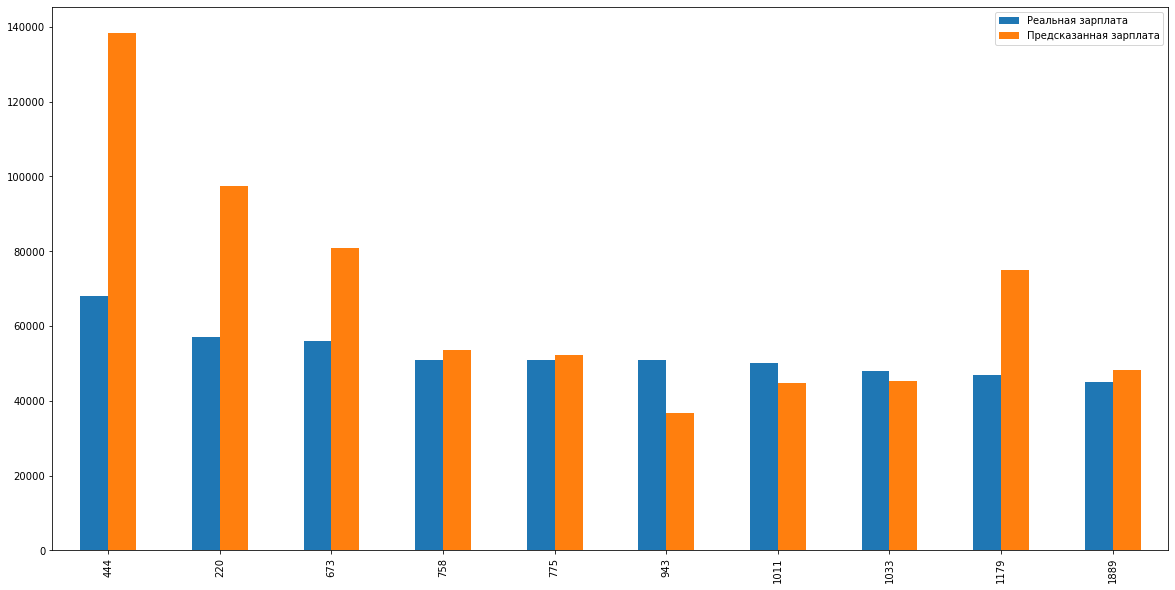

In [70]:
c.nlargest(10,'Реальная зарплата').plot(kind='bar')
plt.show()

Получилось,что модель предсказала намного бОльшие зарплаты,чем есть в реальности. То есть, если верить модели, российские футболисты получают гораздо меньше своих коллег с теми же качественными показателями игры.

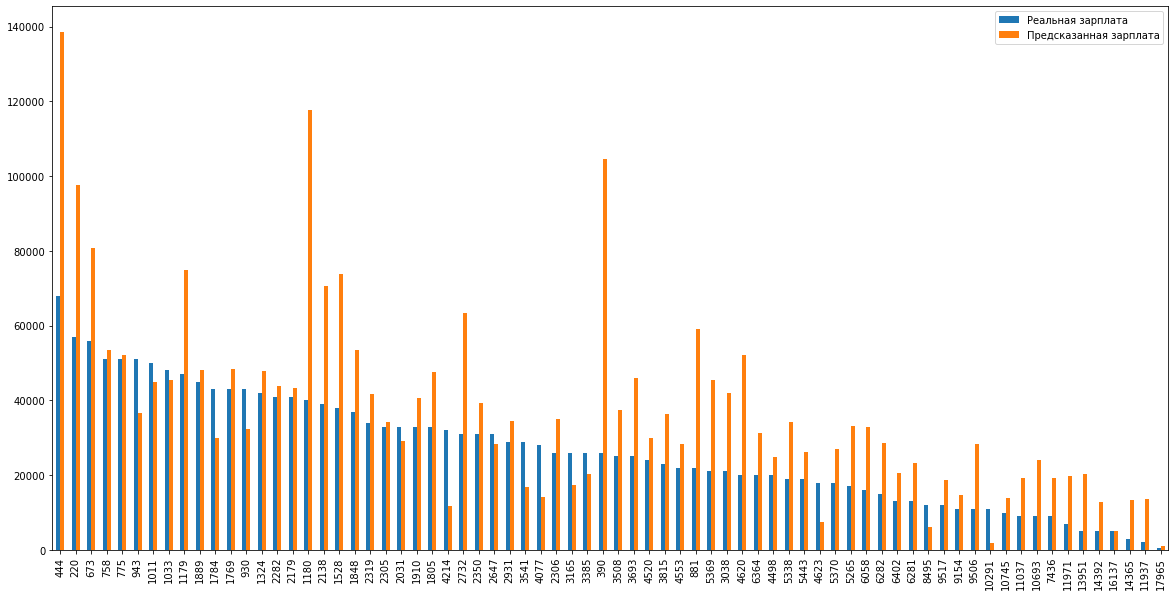

In [68]:
c = pd.DataFrame(a)[(pd.DataFrame(a) >= 0).all(axis=1)]
c.sort_values(by='Реальная зарплата', ascending=False).plot(kind='bar')
plt.show()

Выше: для всех футболистов РПЛ. Видим ту же картину: предсказанные зарплаты куда выше реальных, вопреки консенсусу о котором шла речь ранее.

Чтобы убедиться, что проблема в модели, а не в специфике отечественных игроков, построим модель на основе лиги Holland Eredivisie - успешной, но не самой крупной в сфере, что должно предоставить достаточно сбалансированные данные

In [77]:
erd = df.loc[df['league_name'].isin(['Holland Eredivisie'])]
erd.shape

(492, 52)

In [78]:
scaled_erd = scale.fit_transform(erd[feature_names])

In [79]:
X_test_erd = scaled_erd
y_test_erd = erd[target_name]

R2:	-39.654
MAE:	27234.243


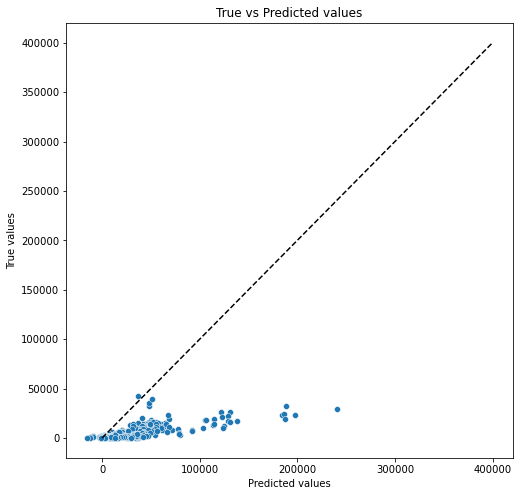

In [80]:
y_test_preds_erd = modelReg.predict(X_test_erd)
evaluate_preds(y_test_erd, y_test_preds_erd)

In [81]:
a1 = {'Реальная зарплата':y_test_erd,'Предсказанная зарплата':y_test_preds_erd}
b1 = pd.DataFrame(a1)
b1['Разница']=b1['Предсказанная зарплата']-b1['Реальная зарплата']
b1

,Реальная зарплата,Предсказанная зарплата,Разница
109,32000.0,188641.071439,156641.071439
214,23000.0,184542.724800,161542.724800
215,29000.0,240295.650071,211295.650071
242,24000.0,186789.735502,162789.735502
314,26000.0,131117.978478,105117.978478
...,...,...,...
18047,1000.0,-11995.161395,-12995.161395
18114,500.0,2747.963814,2247.963814
18120,500.0,-1173.147937,-1673.147937
18304,500.0,-12209.665847,-12709.665847


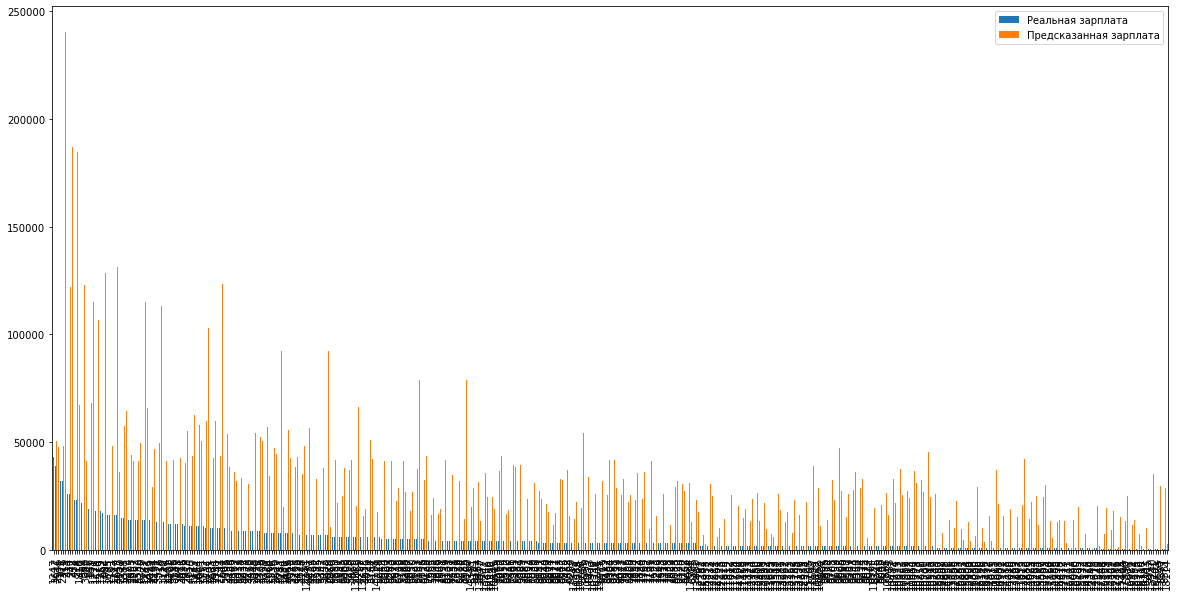

In [82]:
c1 = pd.DataFrame(a1)[(pd.DataFrame(a1) >= 0).all(axis=1)]
c1.sort_values(by='Реальная зарплата', ascending=False).plot(kind='bar')
plt.show()

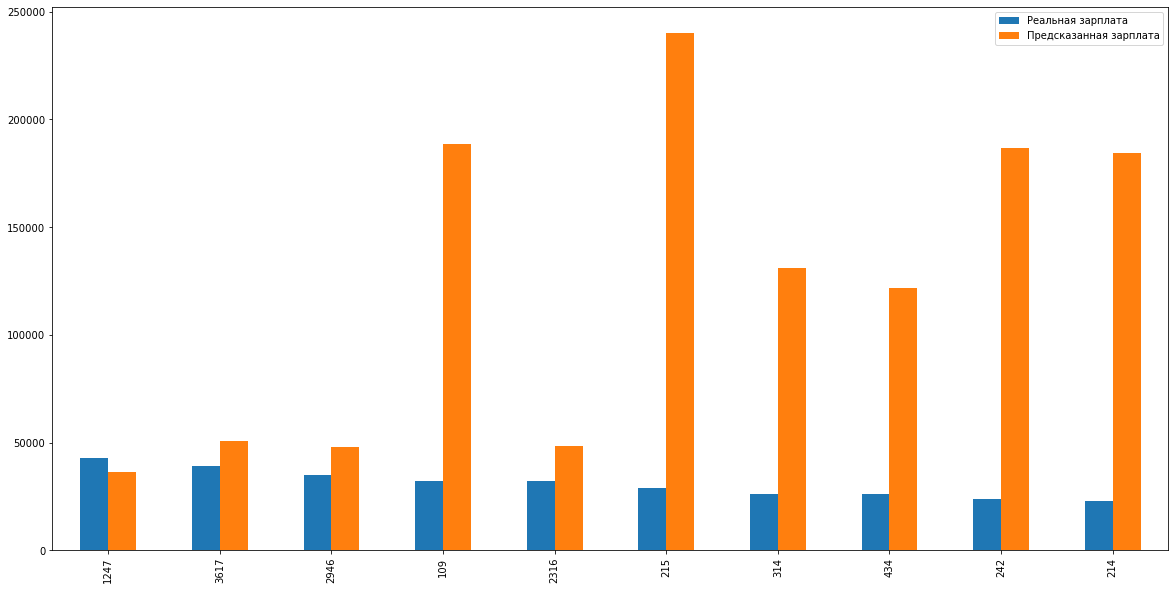

In [83]:
c1.nlargest(10,'Реальная зарплата').plot(kind='bar')
plt.show()

Наблюдаем схожие результаты - похоже, что модель с Адабустингом линейной регресси неоптимальна для наших данных. Теперь построим альтернативную модель на основе Случайного леса и посмотрим, улучшатся ли результаты. 

# Случайный лес

In [84]:
labels = np.array(topfive[target_name])
features = topfive[feature_names]
feature_list = list(features.columns)
features = np.array(features)

In [85]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [86]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2083, 44)
Training Labels Shape: (2083,)
Testing Features Shape: (893, 44)
Testing Labels Shape: (893,)


In [87]:
rf = RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=2, n_estimators=423, random_state=123)

In [88]:
# Опять же, подбор гиперпараметров может занять пару минут

param_grid = {'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': randint(50, 501)}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, 
                              cv = cv, verbose=10, random_state=123, n_jobs = -1)
                                       
rf_random.fit(train_features, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=RandomForestRegressor(bootstrap=False,
                                                   max_depth=30,
                                                   max_features='sqrt',
                                                   min_samples_leaf=2,
                                                   n_estimators=423,
                                                   random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023FF42A8BB0>},
                   random_state=123, verbose=10)

In [89]:
print(rf_random.best_score_)
print(rf_random.best_estimator_)
print(rf_random.best_params_)

0.7655353730049416
RandomForestRegressor(bootstrap=False, max_depth=100, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=453, random_state=123)
{'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 453}


In [90]:
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=423, random_state=123)

R2:	0.993
MAE:	1508.471


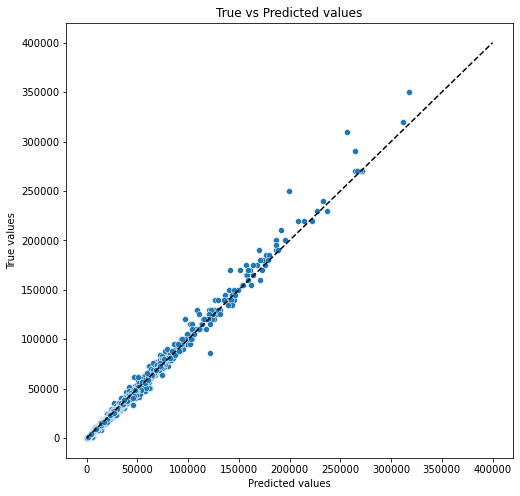

In [91]:
train_labels_preds = rf.predict(train_features)
evaluate_preds(train_labels, train_labels_preds)

R2:	0.764
MAE:	11080.384


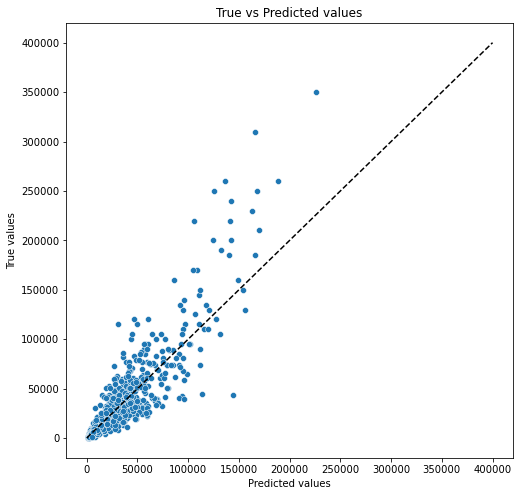

In [92]:
test_labels_preds = rf.predict(test_features)
evaluate_preds(test_labels, test_labels_preds)

In [93]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 11080.38 degrees.


In [94]:
importances = np.array(rf.feature_importances_)

<AxesSubplot:xlabel='Названия признаков'>

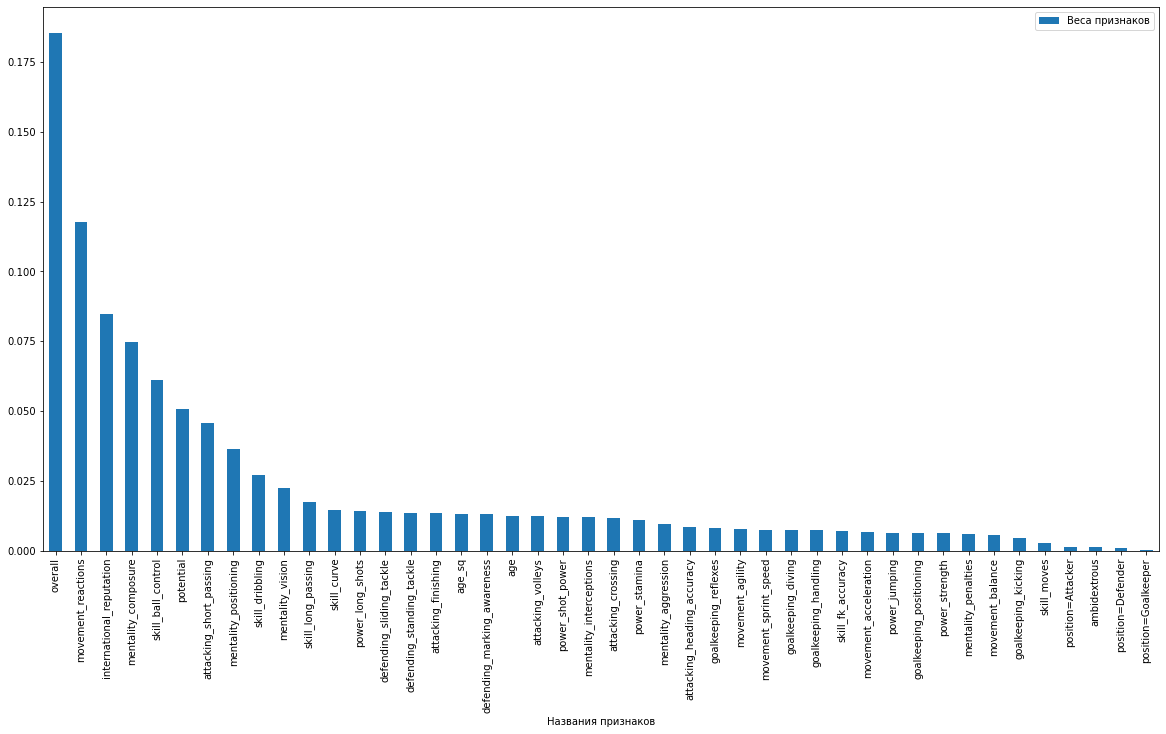

In [95]:
b1 = feature_list
b2 = importances
for_bar2 = pd.DataFrame({'Названия признаков':b1, 'Веса признаков':b2})
for_bar2.sort_values(by='Веса признаков', ascending=False, inplace=True)
plt.rcParams["figure.figsize"] = (20, 10)
for_bar2.plot('Названия признаков', 'Веса признаков', kind='bar')

In [96]:
X_rpl_rf = rpl[feature_names]
y_rpl_rf = rpl[target_name]

R2:	0.804
MAE:	5268.227


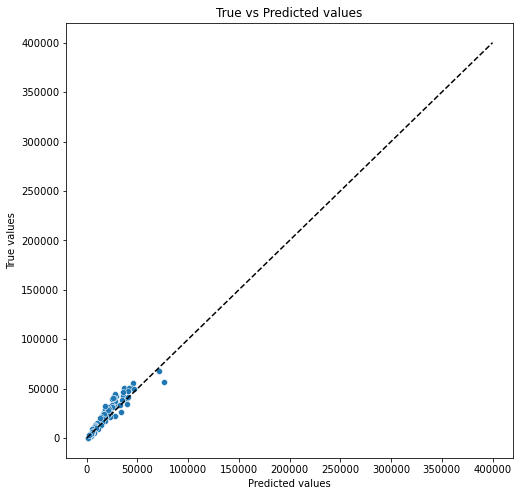

In [97]:
y_rpl_preds_rf = rf.predict(X_rpl_rf)
evaluate_preds(y_rpl_rf, y_rpl_preds_rf)

In [98]:
a2 = {'Реальная зарплата':y_rpl_rf,'Предсказанная зарплата':y_rpl_preds_rf}
b2 = pd.DataFrame(a2)
b2['Разница']=b2['Предсказанная зарплата']-b2['Реальная зарплата']
b2 = b2.sort_values(by='Разница', ascending=False)
b2

,Реальная зарплата,Предсказанная зарплата,Разница
220,57000.0,76185.973207,19185.973207
390,26000.0,33463.356974,7463.356974
881,22000.0,27676.516942,5676.516942
2319,34000.0,39309.889677,5309.889677
444,68000.0,70968.085106,2968.085106
...,...,...,...
4214,32000.0,17749.921198,-14250.078802
2179,41000.0,26388.987392,-14611.012608
2282,41000.0,25622.734437,-15377.265563
1784,43000.0,26948.581560,-16051.418440


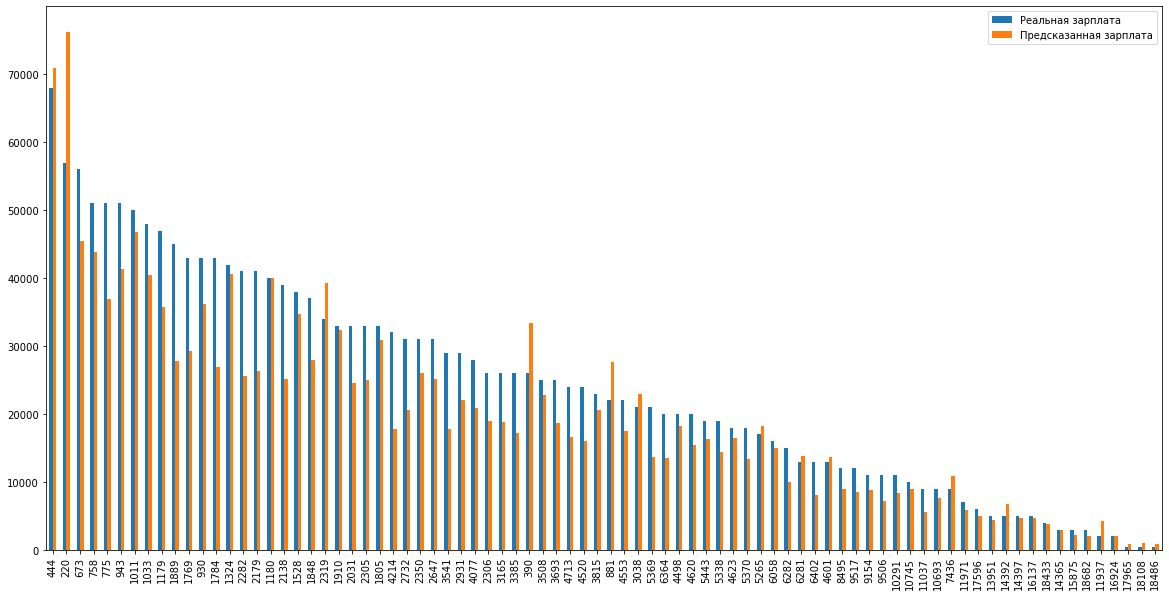

In [99]:
c2 = pd.DataFrame(a2)[(pd.DataFrame(a2) >= 0).all(axis=1)]
c2.sort_values(by='Реальная зарплата', ascending=False).plot(kind='bar')
plt.show()

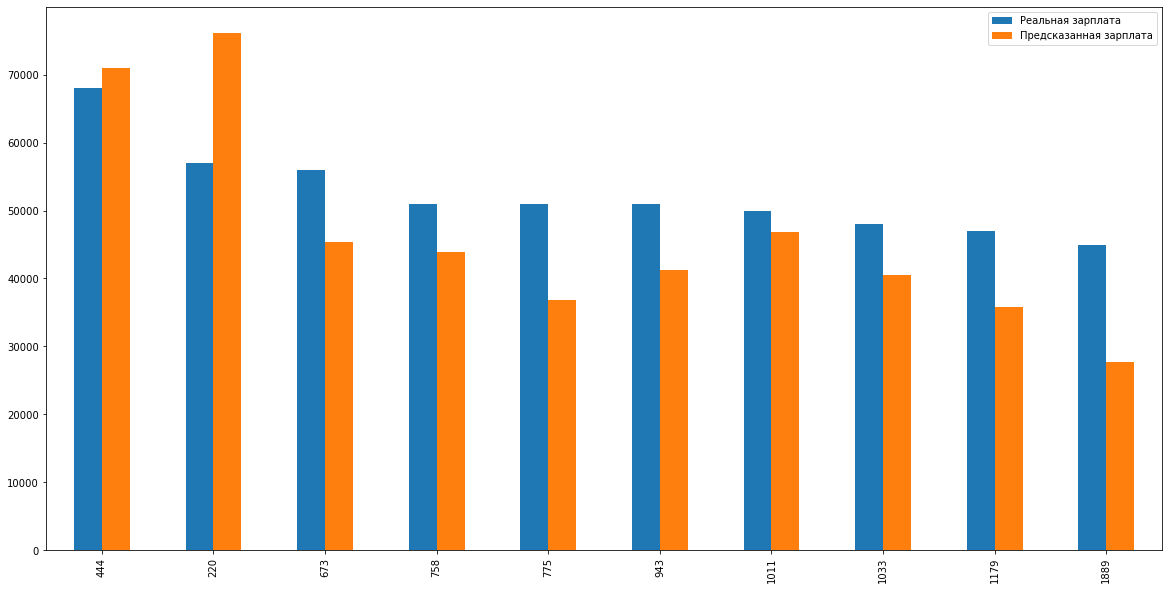

In [100]:
c2.nlargest(10,'Реальная зарплата').plot(kind='bar')
plt.show()

In [101]:
X_test_erd = erd[feature_names]
y_test_erd = erd[target_name]

R2:	-3.895
MAE:	8558.47


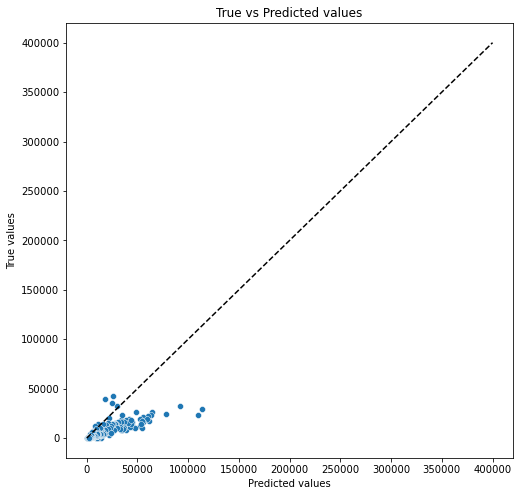

In [102]:
y_test_preds_erd = rf.predict(X_test_erd)
evaluate_preds(y_test_erd, y_test_preds_erd)

In [103]:
a3 = {'Реальная зарплата':y_test_erd,'Предсказанная зарплата':y_test_preds_erd}
b3 = pd.DataFrame(a3)
b3['Разница']=b3['Предсказанная зарплата']-b3['Реальная зарплата']
b3

,Реальная зарплата,Предсказанная зарплата,Разница
109,32000.0,91586.682427,59586.682427
214,23000.0,109529.944838,86529.944838
215,29000.0,113720.646178,84720.646178
242,24000.0,78319.148936,54319.148936
314,26000.0,64624.901497,38624.901497
...,...,...,...
18047,1000.0,3623.542159,2623.542159
18114,500.0,1224.448385,724.448385
18120,500.0,802.324665,302.324665
18304,500.0,1940.721040,1440.721040


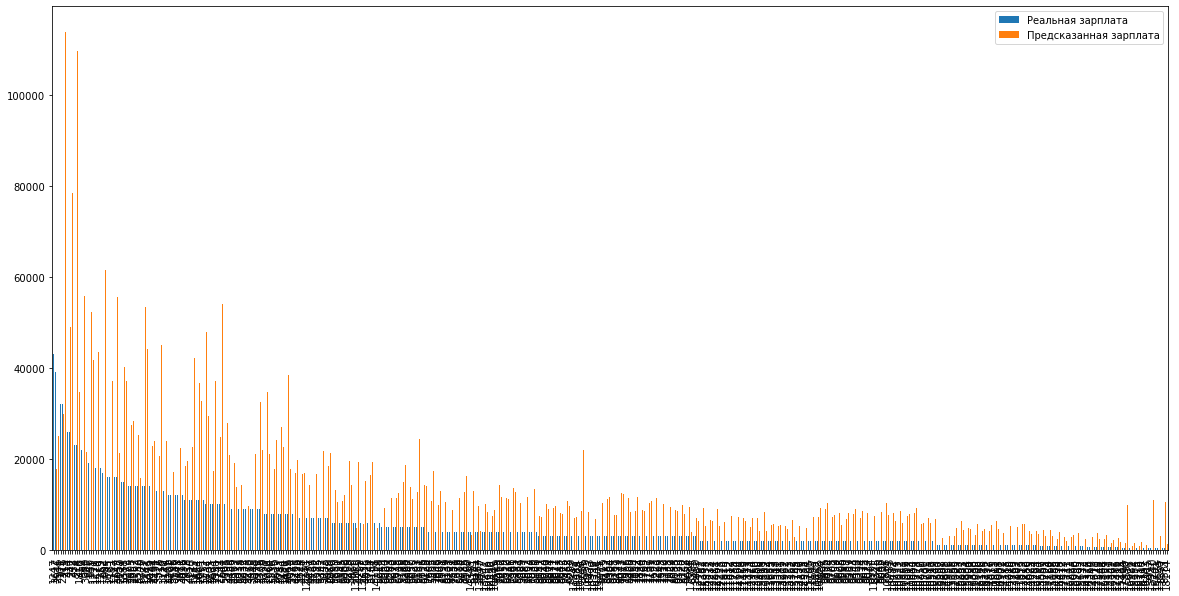

In [104]:
c3 = pd.DataFrame(a3)[(pd.DataFrame(a1) >= 0).all(axis=1)]
c3.sort_values(by='Реальная зарплата', ascending=False).plot(kind='bar')
plt.show()

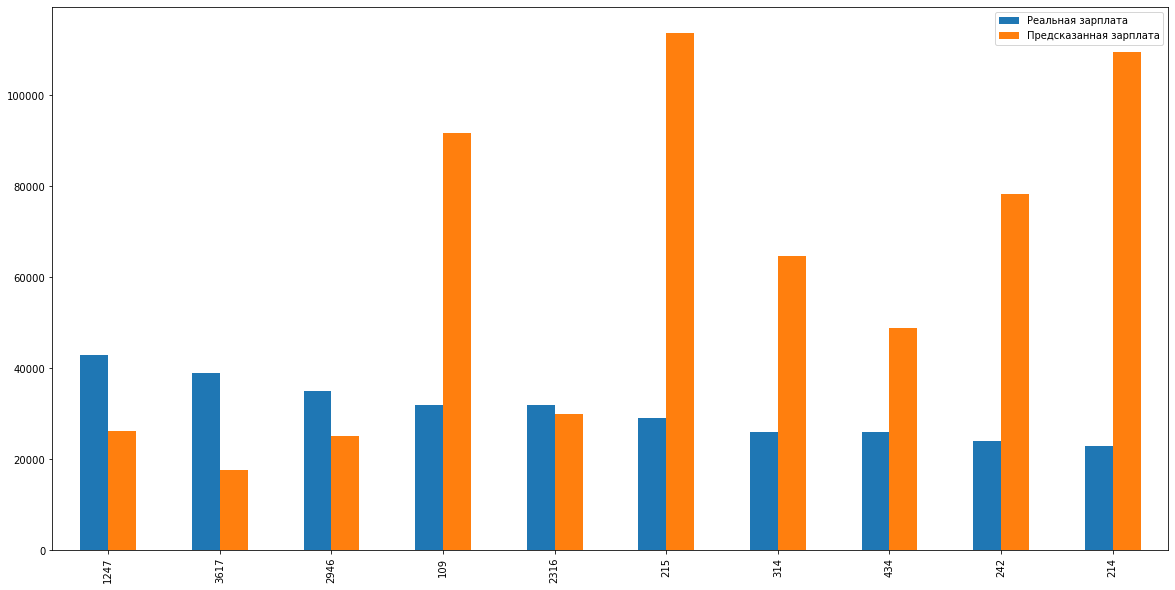

In [105]:
c3.nlargest(10,'Реальная зарплата').plot(kind='bar')
plt.show()

# Результаты и выводы

Самая качественная модель из двух - Случайный лес 

Результаты на тестовой выборке: 
    
    R^2 = 0.764
    MAE = 11080.384
    
Для сравнения результаты на тестовой выборке AdaBoost'a:
    
    R^2 = 0.627
    MAE = 15413.55
    
На графиках также видно, что разброс предсказаний у Случайного леса более предсказуемый, чем у AdaBoost'a
    
P.S.: при нескольких запусках с разных систем, метрики качества для AdaBoost могут варьироваться, но никогда они не превышают метрики качества Случайного леса

RandomForestRegressor
R2:	0.764
MAE:	11080.384


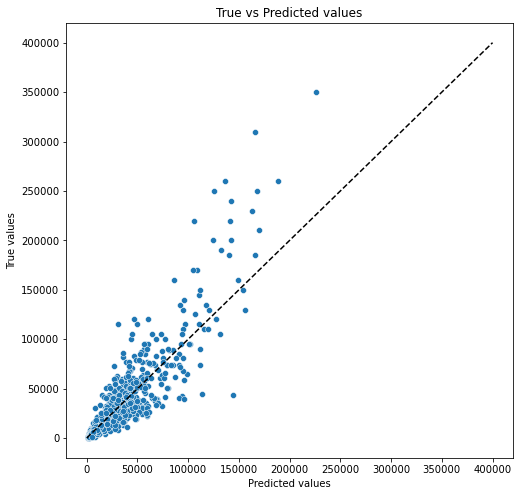

AdaBoostRegressor
R2:	0.627
MAE:	15413.55


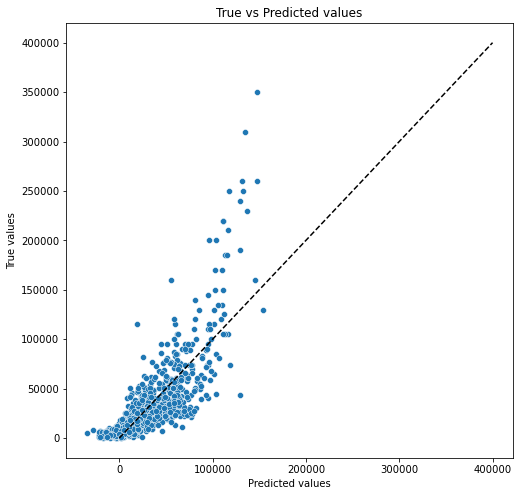

In [106]:
print('RandomForestRegressor')
test_labels_preds = rf.predict(test_features)
evaluate_preds(test_labels, test_labels_preds)

print('AdaBoostRegressor')
y_test_preds = modelReg.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Построим датафрейм с реальными и предсказанными зарплатами (обеими моделями) и их разностью.



In [107]:
a_end = {'Real_wage':y_rpl_rf, 'RF_wage':y_rpl_preds_rf,'Ada_wage':y_rpl_preds}
b_end = pd.DataFrame(a_end)
b_end['RF_diff']=round(b_end['RF_wage']-b_end['Real_wage'], 1)
b_end['Ada_diff']=round(b_end['Ada_wage']-b_end['Real_wage'], 1)
b_end['RF_wage'] = round(b_end['RF_wage'], 1)
b_end['Ada_wage'] = round(b_end['Ada_wage'], 1)
b_end

,Real_wage,RF_wage,Ada_wage,RF_diff,Ada_diff
220,57000.0,76186.0,97552.4,19186.0,40552.4
390,26000.0,33463.4,104521.1,7463.4,78521.1
444,68000.0,70968.1,138483.0,2968.1,70483.0
673,56000.0,45424.3,80836.8,-10575.7,24836.8
758,51000.0,43849.9,53469.9,-7150.1,2469.9
...,...,...,...,...,...
17965,500.0,857.1,1179.1,357.1,679.1
18108,500.0,1041.2,-9441.2,541.2,-9941.2
18433,4000.0,3848.1,-19769.7,-151.9,-23769.7
18486,500.0,864.8,-4478.6,364.8,-4978.6


Согласно описательным статистикам: 

Средняя разница зарплат по версии Леса составила почти -4000 евро в неделю (отриц. знач)

Согласно АдаБусту - чуть менее 8000 евро в неделю (полож. знач)

In [108]:
round(b_end.describe(), 1)

,Real_wage,RF_wage,Ada_wage,RF_diff,Ada_diff
count,82.0,82.0,82.0,82.0,82.0
mean,24213.4,20228.9,31873.5,-3984.5,7660.1
std,16035.8,14818.2,28906.7,5855.1,19754.5
min,500.0,857.1,-27075.1,-17243.1,-32075.1
25%,11000.0,8568.0,14361.6,-7258.5,-5110.7
50%,22500.0,17743.0,29605.4,-3238.2,6608.8
75%,33750.0,27494.5,45260.3,-348.6,14847.4
max,68000.0,76186.0,138483.0,19186.0,78521.1


In [109]:
PosNeg_list = ['Должны получать больше', 'Должны получать меньше']

RF_pos = len(b_end.loc[b_end.RF_diff >= 0])
RF_neg = len(b_end['RF_diff']) - RF_pos
RF_list_diff = [RF_pos, RF_neg]

Ada_pos = len(b_end.loc[b_end.Ada_diff >= 0])
Ada_neg = len(b_end['Ada_diff']) - Ada_pos
Ada_list_diff = [Ada_pos, Ada_neg]

Согласно Лесу почти 80% игроков РПЛ не заслуживают своей зарплаты.

В то время как АдаБуст считает, что большинство (2/3) игроков РПЛ напротив заслуживают своей зарплаты.

Но принимая во внимание метрики качества моделей, легче склониться в пользу результатов Леса - 4/5 футболистов РПЛ получают завышенную заработную плату.

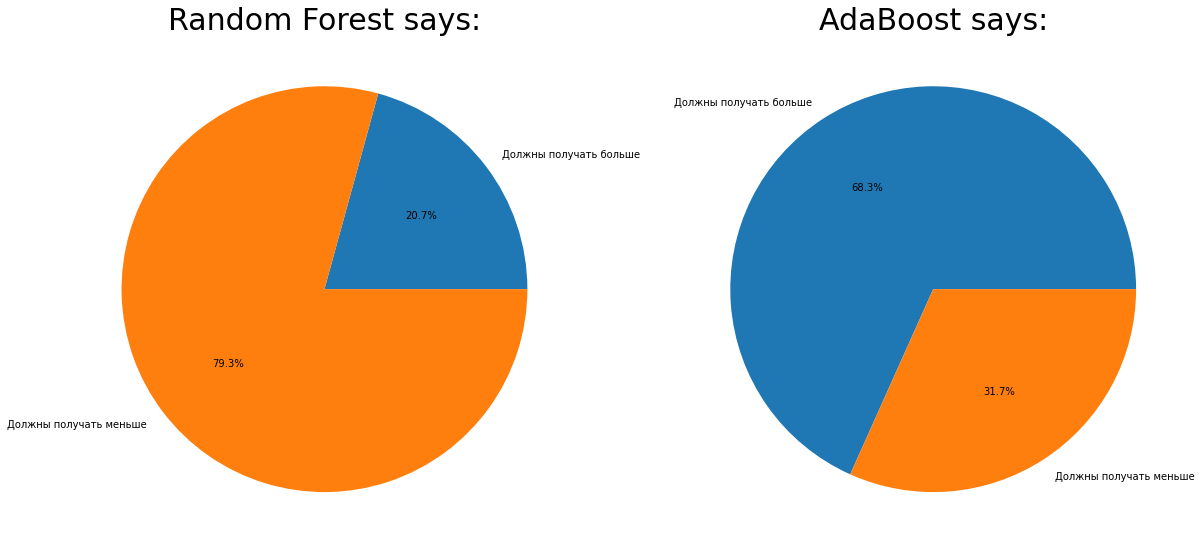

<Figure size 720x504 with 0 Axes>

In [110]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.pie(RF_list_diff, labels = PosNeg_list, autopct = '%1.1f%%')
ax1.set_title('Random Forest says:', fontsize=30)

fig = plt.figure(figsize =(10, 7))
ax2.pie(Ada_list_diff, labels = PosNeg_list, autopct = '%1.1f%%')
ax2.set_title('AdaBoost says:', fontsize=30)

plt.show()

Создадим переменные, которые будут фиксировать оправданность ЗП футболистов РПЛ согласно обеим моделям. Это нужно, чтобы вывести по ним статистику в разрезе Получают больше/меньше чем заслуживают:

In [111]:
b_end['RF_verdict'] = b_end['RF_diff']
b_end.loc[b_end.RF_diff < 0, 'RF_verdict'] = 'Неоправд. ЗП'
b_end.loc[b_end.RF_diff >= 0, 'RF_verdict'] = 'Оправд. ЗП'

b_end['Ada_verdict'] = b_end['Ada_diff']
b_end.loc[b_end.Ada_diff < 0, 'Ada_verdict'] = 'Неоправд. ЗП'
b_end.loc[b_end.Ada_diff >= 0, 'Ada_verdict'] = 'Оправд. ЗП'

b_end

,Real_wage,RF_wage,Ada_wage,RF_diff,Ada_diff,RF_verdict,Ada_verdict
220,57000.0,76186.0,97552.4,19186.0,40552.4,Оправд. ЗП,Оправд. ЗП
390,26000.0,33463.4,104521.1,7463.4,78521.1,Оправд. ЗП,Оправд. ЗП
444,68000.0,70968.1,138483.0,2968.1,70483.0,Оправд. ЗП,Оправд. ЗП
673,56000.0,45424.3,80836.8,-10575.7,24836.8,Неоправд. ЗП,Оправд. ЗП
758,51000.0,43849.9,53469.9,-7150.1,2469.9,Неоправд. ЗП,Оправд. ЗП
...,...,...,...,...,...,...,...
17965,500.0,857.1,1179.1,357.1,679.1,Оправд. ЗП,Оправд. ЗП
18108,500.0,1041.2,-9441.2,541.2,-9941.2,Оправд. ЗП,Неоправд. ЗП
18433,4000.0,3848.1,-19769.7,-151.9,-23769.7,Неоправд. ЗП,Неоправд. ЗП
18486,500.0,864.8,-4478.6,364.8,-4978.6,Оправд. ЗП,Неоправд. ЗП


Согласно Лесу:

В среднем футболисты РПЛ, незаслуживающие своей ЗП, получают на почти 6000 евро в неделю больше, чем должны

При этом футболистам, которым платят оправданно, должны в среднем платить на 3000 евро больше в неделю, согласно их навыкам игры

In [112]:
round(b_end.groupby(by=['RF_verdict']).mean(), 1)

,Real_wage,RF_wage,Ada_wage,RF_diff,Ada_diff
RF_verdict,,,,,
Неоправд. ЗП,25461.5,19625.2,29809.2,-5836.3,4347.7
Оправд. ЗП,19441.2,22537.2,39766.4,3096.1,20325.2


Согласно АдаБусту:

Те, кто получают больше, чем заслуживают, должны получать в среднем на более чем 11 000 евро в неделю меньше.

Напротив для тем, кто заслуживает своей реальной ЗП, должны платить на 16 500 евро больше в неделю.

In [113]:
round(b_end.groupby(by=['Ada_verdict']).mean(), 1)

,Real_wage,RF_wage,Ada_wage,RF_diff,Ada_diff
Ada_verdict,,,,,
Неоправд. ЗП,21038.5,16321.4,9635.9,-4717.1,-11402.6
Оправд. ЗП,25687.5,22043.1,42198.2,-3644.4,16510.7


Посмотрим на графики ЗП для реальных и предсказанных обеими моделями.

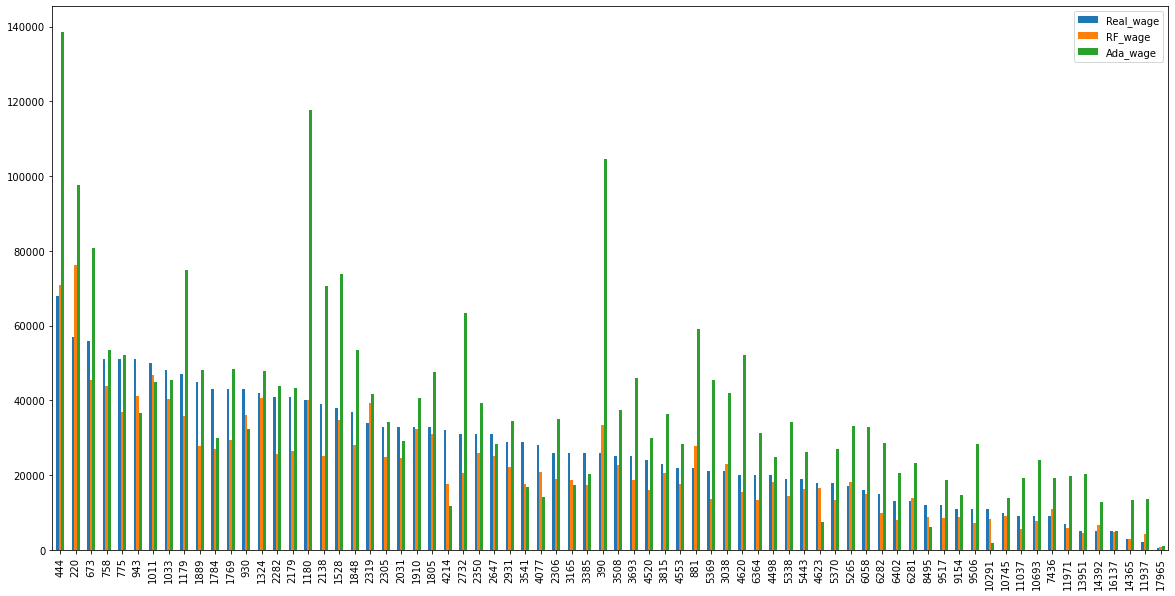

In [114]:
c_end = pd.DataFrame(a_end)[(pd.DataFrame(a_end) >= 0).all(axis=1)]
c_end.sort_values(by='Real_wage', ascending=False).plot(kind='bar')
plt.show()

Напоследок, посмотрим на тот же график, но более увеличенный и наглядный:

АдаБуст склонен предсказывать зарплаты выше, чем реальные и ЗП от Леса

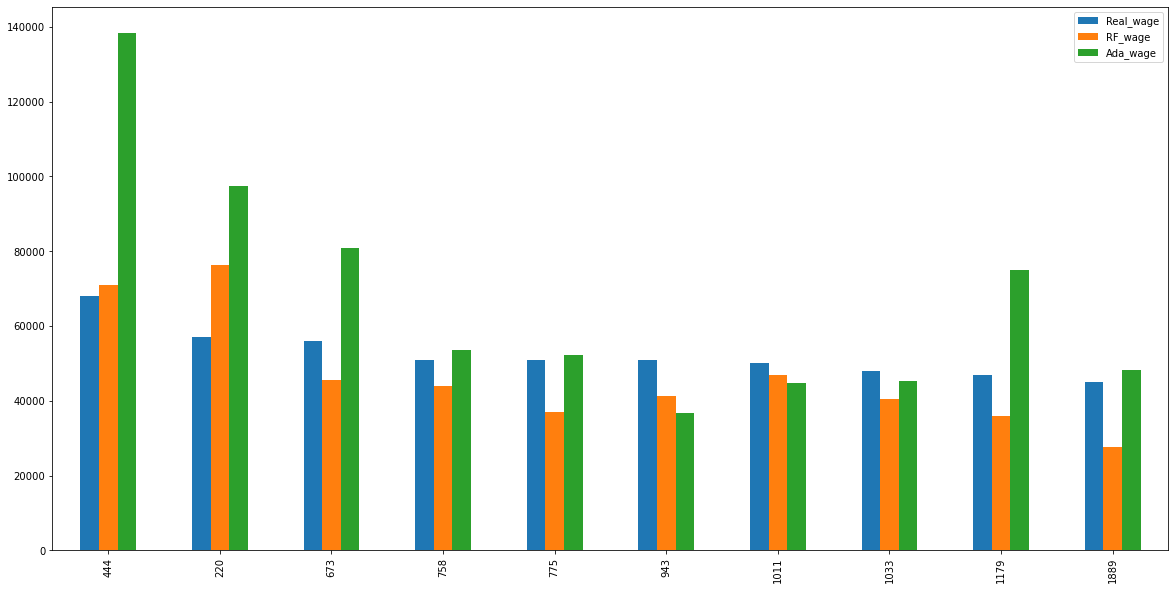

In [115]:
c_end.nlargest(10,'Real_wage').plot(kind='bar')
plt.show()

По итогу работы мы можем видеть, что при построении более точной модели на основе Случайного леса, 79.3% отечественных игроков получают зарплату выше, чем игроки по миру с такими же навыками игры. Таким образом, если верить построенной модели, изначальный консенсус о том, что российским игрокам переплачивают, подтверждается. 

Разумеется, это исследование не может взять во внимание внешние факторы (в основном - социоэкономические, но также и политические), которыми могут быть обусловлены зарплаты в зависимости от государства - мы смотрим строго фактическую зависимость от навыков и характеристик игрока. Вероятно, в будущем будет место более обширному исследованию, учитывающему куда больше факторов, и наши результаты смогут быть использованы как его часть, от которой исследователи смогут отталкиваться при дальнейшем изучении проблемы!